<a href="https://colab.research.google.com/github/mvaldenegro/UncertaintyML-course-ESSAI-labs/blob/main/02_eval_uncertainty_calibration_post_lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

In [1]:
!git clone https://github.com/mvaldenegro/UncertaintyML-course-ESSAI-labs

Cloning into 'UncertaintyML-course-ESSAI-labs'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 50 (delta 20), reused 11 (delta 3), pack-reused 0
Receiving objects: 100% (50/50), 2.65 MiB | 20.59 MiB/s, done.
Resolving deltas: 100% (20/20), done.


## Evaluating the performance of probabilistic models

We first implement two metrics for Bayesian models:

* **Coverage** for regression
* **Brier Score** for classification

Note: in the definitions used below, we will have the following entities:

* $y\in\mathbb{R}^N$ is the vector containing the ground truth.
* $\hat{y}$ is a vector of $M$ probability distributions (the predictive posterior probabilities $q(y|x, \theta)$), $x$ being a set of $N$ data points and $\theta$ the model parameters. We may have a close form of these distributions, or samples obtained, e.g., using Monte-Carlo methods. In the former case, the predictions will be a $M \times N$ matrix which we call $\hat{Y}$.

  We can thus calculate the per-datapoint mean and standard deviations:
  $$
  \mu_{\hat{Y}}^{(i)} = \frac{\sum_{j=1}^M \hat{y}^{(i)}_j}{M} \\
  \sigma_{\hat{Y}}^{(i)} = \sqrt{\frac{\sum_{j=1}^M \left(\hat{y}^{(i)}_{j} - \mu_{\hat{Y}}^{(i)}\right)^2}{M}}
  $$


For each datapoint, we can hence construct a 95% confidence interval, e.g., by summing and subtracting 2*std from the mean prediction:
$$
\text{CI}_i = \left[\mu_{\hat{Y}}^{(i)} - 2\sigma_{\hat{Y}}^{(i)}, \mu_{\hat{Y}}^{(i)} + 2\sigma_{\hat{Y}}^{(i)}\right]
$$

Note: we will implement these metrics using NumPy: these can be further adapted to Pytorch or Tensorflow


### Coverage

Coverage calculates whether the confidence interval contains the ground truth for each of the datapoints within the dataset. It is hence an extension of accuracy for probabilistic models for regression.

$$
\text{coverage}(y,\hat{y}) = \frac{\sum_{i=1}^{N} \mathbb {1}_{\left[ y^{(i)} \in \text{CI}_i   \right]}}{N}
$$

Note: $\mathbb{1}_{[\text{condition}]}$ is the **indicator function**, which returns 1 if the condition in brackets is true, 0 if false:

$$
\mathbb{1}_{[\text{condition}]} =
  \begin{cases}
    1 &\text{if condition true} \\
    0 &\text{otherwise}
  \end{cases}
$$

**Your task**:
you are given `y_true`, the ground truth of a regression model (a NumPy ndarray of size `(N,)`) and `y_pred`, the prediction output of a `StochasticRegressor` model from `keras_uncertainty`.

_Tips_: you can find the weights of a pretrained MCDropout regressor on the GitHub page, under the folder `files`, its name is `mcdropout_regression_weights.keras`. The corresponding architecture is the following:

```python
backbone_dropout = keras.models.Sequential([
    keras.Input(shape=(1,)),
    keras.layers.Dense(units=16, activation="relu"),
    keras_uncertainty.layers.StochasticDropout(dropout_p),
    keras.layers.Dense(units=16, activation="relu"),
    keras_uncertainty.layers.StochasticDropout(dropout_p),
    keras.layers.Dense(units=1)
])
```
In addition, you will also find there the predictions corresponding to the test set used in the previous lab (`mcdropout_regression_test_prediction.npy`).

In [50]:
x_test_max = 7
n_test = 1000
x_test = np.linspace(-x_test_max, x_test_max, 1000)
y_test = np.sin(x_test)
# get predictions here
y_pred = np.load("/content/UncertaintyML-course-ESSAI-labs/files/mcdropout_regression_test_prediction.npy")

In [4]:
def coverage(y_true, y_pred):
  pred_mean, pred_std = y_pred # prediction for StochasticRegressors is (mean, std)
  pred_mean = pred_mean.squeeze() # get rid of singleton dimensions (1000, 1) -> (1000)
  pred_std = pred_std.squeeze()
  ci_lower = pred_mean - 2 * pred_std
  ci_upper = pred_mean + 2 * pred_std
  is_in_interval = np.bitwise_and(y_true > ci_lower, y_true < ci_upper)
  # is_in_interval is a vector of booleans, it tells whether each single datapoint
  # falls in the confidence interval (1=True, 0=False)
  coverage_val = is_in_interval.mean()
  # by requesting the mean of is_in_interval, NumPy converts the array from boolean
  # to integer, calculates the sum of the values (-> how many ground truth values
  # fall within the CI) then divides by the number of datapoints (-> this is coverage)
  return coverage_val


In [5]:
coverage(y_test, y_pred)

0.645

Interpretation: considering uncertainty, the model covers 65% of the test samples

### Brier Score

The Brier Score is an extension of the mean square error for probability distributions for classification. It requires the ground truth to be expressed as per-class probabilities. Hard labels need to be expressed using one-hot encodings. The corresponding predictions can be computed e.g. by _voting_.

Summing up, by supposing a $C$-way classification problem and a test data point $x^{(i)}$ with corresponding ground truth $y^{(i)}$:

* $y^{(i)} = \begin{bmatrix} y_1^{(i)} & y_2^{(i)} & \dots & y_C^{(i)} \end{bmatrix}, y_c^{(i)} \in [0,1]~\forall c, \sum_c y_c^{(i)} = 1$

* $\hat{y}^{(i)} = \begin{bmatrix} \hat{y}_{11}^{(i)} & \dots & \hat{y}_{1C}^{(i)}  \\ \hat{y}_{21}^{(i)} & \dots & \hat{y}_{2C}^{(i)} \\ \vdots & \ddots & \vdots \\ \hat{y}_{M1}^{(i)} & \dots & \hat{y}_{MC}^{(i)} \end{bmatrix}, \hat{y}_{jc}^{(i)} \in [0,1]~\forall j,c; \sum_c \hat{y}_{jc}^{(i)} = 1~\forall j \in {1,\dots,M}$

  We can summarize the output distribution by taking the mean across the various samples (components of the
  ensemble, number of runs for VI...):

  $$
  \bar{\hat{y}}^{(i)} = \begin{bmatrix}\frac{\sum_{i=1}^{M}\hat{y}_{i1}^{(i)}}{M} & \dots & \frac{\sum_{i=1}^{M}\hat{y}_{iC}^{(i)}}{M} \end{bmatrix}
  $$

We can then evaluate our model by having a sample of $N$ test data points, computing $\bar{\hat{y}}$ for each of them:

$$
\text{BS}(y, \hat{y}) = \frac{\sum_{i=1}^{N}\sum_{c=1}^{C}\left(y_{c}^{(i)}-\bar{\hat{y}}_{jc}^{(i)}\right)^2}{N}
$$

Note: if we have a binary classification problem, the formulation above simplifies, since $y$ is a 0-1 scalar and $\hat{y}$ a vector of probabilities of assignment to the positive class.

**Your task**: recover one of yesterday's implementations of BNNs for MNIST classification and obtain the output from `StochasticClassifier` (or `EnsembleClassifier`) for the MNIST test set. Compute the brier score associated with the prediction.



In [7]:
### Example with a non-Bayesian NN for classification using MNIST

import keras
import tensorflow as tf

model_mnist = keras.Sequential([
    keras.layers.Input((28, 28, 1)), # data as image: heigth x width x channels. MNIST is grayscale » 1 channel
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(10),
    keras.layers.Activation("softmax")
])

model_mnist.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_mnist.load_weights("/content/UncertaintyML-course-ESSAI-labs/files/nn_mnist_weights.keras")

_, (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

y_pred_mnist = model_mnist.predict(x_test_mnist)


313/313 [==============================] - 0s 1ms/step


How is the prediction expressed?

If you use a deterministic NN or a BNN wrapped by a StochasticClassifier, the output will be a matrix like this

```
[
  [0.5, 0.2, 0.3],
  [0.3, 0.1, 0.6]
]
```
with the datapoints on the rows and the classes on the columns. This is hence a prediction for 2 test datapoints on a 3-way classification problem.

The ground truth is instead this:
```
Index of the classes
[0, 1]
```
or this:
```
One-hot encoding
[
  [1, 0, 0],
  [0, 1, 0]
]
```
The Brier Score works on one-hot encoding of the labels.

In [26]:
def brier_score(y_true, y_pred, label_is_one_hot=False):
  if not label_is_one_hot:
    onehot = np.zeros((y_true.size, y_true.max() + 1))
    onehot[np.arange(y_true.size), y_true] = 1
  else:
    onehot = y_true
  return ((y_pred - onehot)**2).sum()

In [27]:
brier_score(y_test_mnist, y_pred_mnist)

623.2485476287854

## Calibration

Calibration is a measure of **trust** which concerns the relationship between accuracy and confidence.
We expect accuracy that models have in their predictions to be high when the confidence assigned to these predictions is high; viceversa, low confidence should be related to low accuracy.
The usage of accuracy, in this case, makes the concept of calibration quickly applicable to classification problems.

We use the definition of confidence as the level of probability assigned to the predicted class (NB there are also other definitions, like entropy).
If we consider the predictive posterior $P(y|x)$ as $\bar{\hat{y}}$ which we consideded before, then $\text{confidence}(\hat{y}) = \max_{c\in\{1,\dots,C\}}\left(\bar{\hat{y}}_c\right)$. NB: we are talking about **max**, not **argmax** (which is related to the predicted class instead).



### Reliability plots

We divide the 0-1 range for confidence in $K$ bins (e.g., $[0.0,0.1),[0.1,0.2),\dots,[0.9,1.0]$). We call each of these bins $B_k, k\in\{1,\dots,K\}$.
We assign each of the data points in our test dataset to these bins.
We then retrieve the mean accuracy attained by the model on these points:
$$
\text{Acc}(B_k) = \sum_{i=1}^{N}{\mathbb{1}_{\left[i\in B_k\right]}\frac{\text{Acc}(y_i, \hat{y}_i)}{N_k}},
$$
where $N_k$ indicates the number of elements in bin $B_k$.


A reliability plot can be created as a plot with confidence on the x axis and accuracy on the y axis

![](https://www.researchgate.net/profile/Anand-Avati/publication/321160854/figure/fig2/AS:562618466344960@1511150103061/Reliability-curve-calibration-plot-of-the-model-output-probabilities-on-the-test-set.png)

A perfect calibration should happen when confidence = accuracy (black dotted line).


**Your task:** below is a code for creating reliability plots using NumPy. You will notice that the functions for obtaining accuracy and confidence for probabilistic classifiers is incomplete. Complete these formula taking into account that the `predictions` are the output of a `StochasticClassifier`.
Then, use the `reliability_vector` and the `reliability_plot` functions to plot the reliability plot associated with the data from the MNIST classification example.


In [38]:
def accuracy_prob_models(predictions, ground_truth):
  assigned_class = predictions.argmax(1)
  # index of row-wise maximum of confidence
  return (assigned_class == ground_truth).mean()

def confidence_prob_models(predictions):
  # confidence is row-wise maximum, the confidence assigned by the model
  # to the predicted class
  return predictions.max(axis=1)

def confidence_binning(confidence_vector, n_bins=10):
  bins = np.linspace(1/n_bins, 1, n_bins)
  return np.digitize(confidence_vector, bins), bins

def reliability_vector(predictions, ground_truth, n_bins=10):
  '''
  Given predictions and ground truth, calculates the confidence scores associated
  with the predictions, bins the confidence into n_bins equispaced in the [0,1]
  line, then compute the per-bin accuracy.
  Returns a 1-d array of n_bins elements containing the per-bin accuracy, and an
  array containing the cutoffs of each bin.
  '''
  confidence_scores = confidence_prob_models(predictions)

  bins_composition, bins_cutoffs = confidence_binning(confidence_scores, n_bins)

  mean_accuracy_per_bins = np.full((n_bins,), fill_value=np.nan)
  bin_counts = np.bincount(bins_composition)

  for i in range(n_bins):
    if i > bins_composition.max():
      break
    if bin_counts[i] > 0:
      group_accuracy = accuracy_prob_models(
          predictions[bins_composition==i],
          ground_truth[bins_composition==i]
        )
      mean_accuracy_per_bins[i] = group_accuracy

  return mean_accuracy_per_bins, bins_cutoffs, bin_counts

def reliability_plot(reliability_vector, bins_cutoffs, clear_nans=True):
  bins_delta = bins_cutoffs[1] - bins_cutoffs[0]
  x_axis = bins_cutoffs - bins_delta/2

  if clear_nans:
    x_axis = x_axis[~np.isnan(reliability_vector)]
    reliability_vector = reliability_vector[~np.isnan(reliability_vector)]

  fig, ax = plt.subplots()
  ax.scatter(
      x_axis,
      reliability_vector
  )
  ax.set_xlim((0,1))
  ax.set_ylim((0,1))
  line = mlines.Line2D([0, 1], [0, 1], color='red')
  transform = ax.transAxes
  line.set_transform(transform)
  ax.add_line(line)
  plt.plot(x_axis, reliability_vector)
  plt.show()



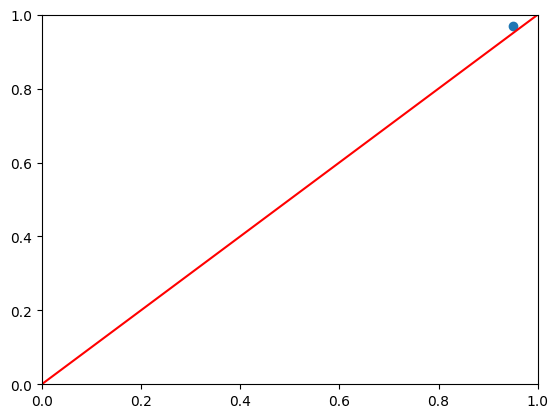

In [41]:
# use MNIST test results here
rv, cutoffs, _ = reliability_vector(y_pred_mnist, y_test_mnist)
reliability_plot(
    rv, cutoffs
    # np.array([np.nan, 0.25, 0.55, 0.45, 0.52, 0.50, 0.67, 0.92, 0.99, 0.98, 0.99]),
    # np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])
)

Why the result is just a point? We can quickly identify the reason:

In [31]:
print("Confidence bins")
print(cutoffs)
print("\n")
print("Accuracy per confidence bin")
print(rv)

Confidence bins
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Accuracy per confidence bin
[   nan    nan    nan    nan    nan    nan    nan    nan    nan 0.9688]


The reason is that the mode is **extremely confident** in all of its predictions. There are no datapoints in the $[0, 0.9)$ intervals for confidence (hence the nan) and all predictions are above 0.9 in confidence.
The model also has a high accuracy (96.88%) thus we get a "good calibration".
This is one of the issues with MNIST: it's an extremely easy dataset.

You may try to re-run the reliability plot on a BNN instead of a deterministic one, and see if the results change.

### Calibration Error

The calibration error can be easily computed out of the binning procedure carried out for obtaining the reliability plots

$$
\text{CE}(y, \hat{y}) = \sum_{k=1}^{K} \left\vert \text{Acc}(B_k) - \text{Conf}(B_k) \right\vert
$$

In [42]:
def calibration_error(y_pred, y_true):
  accuracy_per_bin, cutoffs, _ = reliability_vector(y_pred, y_true)

  bins_delta = cutoffs[1] - cutoffs[0]
  bins_midpoint = cutoffs - bins_delta/2

  # remove nans
  bins_midpoint = bins_midpoint[~np.isnan(accuracy_per_bin)]
  accuracy_per_bin = accuracy_per_bin[~np.isnan(accuracy_per_bin)]

  return np.sum(np.abs(accuracy_per_bin-bins_midpoint))




In [37]:
calibration_error(y_pred_mnist, y_test_mnist)

0.01880000000000004

### Expected Calibration Error

One of the issues with CE is that all bins are equally weighted. It would make more sense to have bins with more data be weighted more than others. ECE compensates for that:

$$
\text{ECE}(y, \hat{y}) = \frac{\sum_{k=1}^{K}N_k\cdot \left\vert \text{Acc}(B_k) - \text{Conf}(B_k) \right\vert}{N}
$$

As defined before, $N_k$ is the number of elements belonging to bin $k$.

In [43]:
def expected_calibration_error(y_pred, y_true):
  accuracy_per_bin, cutoffs, bin_size = reliability_vector(y_pred, y_true)

  bins_delta = cutoffs[1] - cutoffs[0]
  bins_midpoint = cutoffs - bins_delta/2

  # remove nans
  bins_midpoint = bins_midpoint[~np.isnan(accuracy_per_bin)]
  accuracy_per_bin = accuracy_per_bin[~np.isnan(accuracy_per_bin)]

  return np.sum(bin_size * np.abs(accuracy_per_bin-bins_midpoint)) / bin_size.sum()

In [44]:
expected_calibration_error(y_pred_mnist, y_test_mnist)

0.01880000000000004

Question to reason on: why is the ECE the same as CE?

### Calibration for regression tasks

While models for classification come with an inherent estimate of confidence, this is not true in the case of regression.
Restricting to regression for 1-d targets, in probabilistic models we have a predictive posterior with a certain _precision_ (i.e., inverse of variance). We can intuitively think of a relationship whereas high precision $\Leftrightarrow$ high confidence.

Specifically, we can build **confidence intervals** for a given prediction. For this, we have to fix a **confidence level** $\alpha$ and derive the corresponding interval around a given point, usually the expected value of the predictive posterior; in the case of a Gaussian, we build the interval around $\mu$.

![](https://d37djvu3ytnwxt.cloudfront.net/assets/courseware/v1/3c2230f2c98f3c61fcb4a4884ba96f84/asset-v1:DelftX+OT.1x+3T2016+type@asset+block/Normal_critical_values.png)
Creation of a confidence interval for a Gaussian distribution (in the image denoted as $\underline{z}$) around its expected value with three confidence levels $\alpha=0.950, 0.990, 0.999$. _Image provided by TU Delft in the ["Note on the interpretation of confidence interval" course](https://ocw.tudelft.nl/course-readings/note-interpretation-confidence-interval/) under the CC-BY-SA License_.

For a Gaussian predictive posterior $Z=P(Y|X)$ with mean $\mu$, the task of determining the confidence interval boils down to determine the bounds $z_l$ and $z_u$ such as

$$
P(z_l \leq \mu \leq z_u) = \alpha
$$

In case the predictive posterior is a continuos Gaussian, the solution is $z_l = z_{\frac{1-\alpha}{2}} = \Phi^{-1}\left(\frac{1-\alpha}{2}\right)\cdot\sigma + \mu$; $\Phi^{-1}$ indicating the inverse cumulative distribution function of the standard Gaussian. Due to the symmetry of the Gaussian distribution, $z_u$ can be quickly computed as $2\mu - z_{l}$.

In this way, a high-confidence interval will tend to be quite wide, while a low-confidence intervall will be thin around the expected value.

Now that we have determined how to calculate the confidence intervals, we need to translate the concept of calibration to regression problem. The reliability plot for the regression problem can be built like this:

Instead of doing confidence binning (like before), we:
* Fix equispaced confidence values, e.g., $0.0, 0.1, \dots ,0.9, 1.0$, call each of them $\alpha_k, k=1,\dots,K$. (NB: if we have a predictive posterior with unbounded support, we might wanna skip the value 1.0)
* $\forall \alpha_k$:
  * $\forall x^{(i)} \in X$ test dataset:
    * Calculate the confidence interval for $\hat{y}$ based on $\alpha_k$
    * Calculate the coverage, accuracy metric for regression, $c_k^{(i)} \doteq \text{Coverage}(y, \hat{y})_{\alpha_k}$
    * Add $c_k^{(i)}$ to the plot

Practical notes:
* Using SciPy (or PyTorch, or Tensorflow) we can quickly compute the inverse CDF of a generic Gaussian. In SciPy, the command is `scipy.stats.normal(μ, σ).ppf(α)`, where μ, σ are the mean and std (NB, not the variance!) and α is the quantile. PPF stands for "Percent Point Function", which is another term for the inverse CDF.

Statistical distributions in SciPy accept arrays as arguments, so `scipy.stats.normal([μ1, μ2], [σ1, σ2]).ppf(α)` will return an array of two scalars, the α-th quantile referred to the Gaussian with mean μ1 and std σ1 and the α-th quantile referred to the Gaussian with mean μ2 and std σ2.

We can additionally get multiple quantiles by passing a column vector as α:
we can define `α = np.array([α1,..., αk])` then call `scipy.stats.normal([μ1, μ2], [σ1, σ2]).ppf(α[:, np.newaxis])` to obtain all the α1,..., αk quantiles for the two Gaussians.
NB: Don't skip the transposition into column vector (`α[:, np.newaxis]`)!


In [45]:
def reliability_vector_regression(prediction, ground_truth, n_bins=10):
  confidence_cutoffs = np.linspace(0, 1, n_bins+1)[:, np.newaxis] # already prepare the correct shape
  quantiles = (1 - confidence_cutoffs) / 2

  predictions_mean, predictions_std = prediction
  interval_lower_bound = stats.norm(predictions_mean.squeeze(), predictions_std.squeeze()).ppf(quantiles)
  interval_upper_bound = 2 * predictions_mean.squeeze() - interval_lower_bound

  in_interval = (ground_truth >= interval_lower_bound) & (ground_truth <= interval_upper_bound)
  coverage = in_interval.mean(1)

  return coverage, confidence_cutoffs

def reliability_plot_regression(reliability_vector, confidence_cutoffs):
  fig, ax = plt.subplots()
  ax.scatter(
      confidence_cutoffs,
      reliability_vector
  )
  ax.set_xlim((0,1))
  ax.set_ylim((0,1))
  line = mlines.Line2D([0, 1], [0, 1], color='red')
  transform = ax.transAxes
  line.set_transform(transform)
  ax.add_line(line)
  plt.plot(confidence_cutoffs, reliability_vector)
  plt.show()

Let's try it on the toy regression...

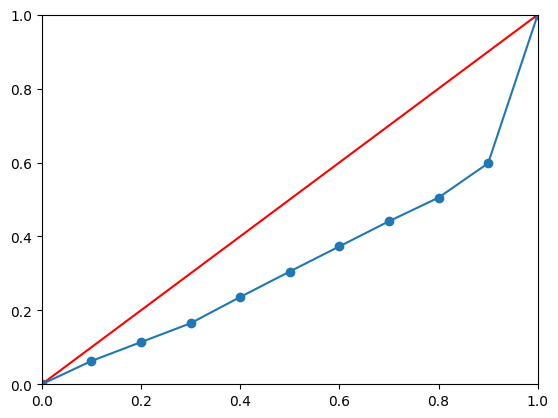

In [52]:
rv, cc = reliability_vector_regression((y_pred[0], y_pred[1]), y_test)
reliability_plot_regression(rv, cc)

**Final task**: let us subset the predictions and the ground truth to only the units in the train set lying in the interval [-3.14, 3.14]. This should correspond (roughly) to the distribution of the training data. Does something change now?

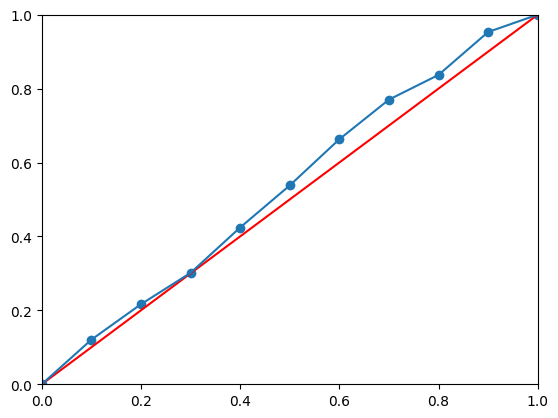

In [53]:
in_distribution_points = np.bitwise_and(x_test > -3.14, x_test < 3.14)
# this is a vector of booleans which we can use to slice the data

y_test_in_dist = y_test[in_distribution_points]
y_pred_in_dist = y_pred[:, in_distribution_points]

rv, cc = reliability_vector_regression((y_pred_in_dist[0], y_pred_in_dist[1]), y_test_in_dist)
reliability_plot_regression(rv, cc)